<a href="https://colab.research.google.com/github/KonstantinElfimow/E-Commerce-Analysis/blob/main/e_commerce_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Сделать RFM-анализ https://www.kaggle.com/datasets/carrie1/ecommerce-data. Выявить лояльность пользователей. Посчитать продуктовые метрики.

In [1]:
! gdown 1YpyajgsyZM07df7ibglOx5gjjqzwcE0P

Downloading...
From: https://drive.google.com/uc?id=1YpyajgsyZM07df7ibglOx5gjjqzwcE0P
To: /content/archive.zip
100% 7.55M/7.55M [00:00<00:00, 40.4MB/s]


In [2]:
! unzip '/content/archive.zip'

Archive:  /content/archive.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 1. Исследование данных на качество и предобработка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.ticker import MultipleLocator
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from typing import Tuple
import math

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

In [4]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1', skipinitialspace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Переведу CustomerID к int, InvoiceDate - к timestamp

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [6]:
# напишем функцию первичной проверки данных
def check_data(data_df):
  '''Функция для вывода общих сведений о датафрейме'''
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  plt.figure(figsize=(10, 6))
  sns.heatmap(df.sample(int(len(data_df) * 0.01)).isna().T);
  plt.suptitle('Оценка пропусков на heatmap')
  plt.show()
  print()
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление количественных данных:' + '\033[0m')
  for numeric_column in data_df.select_dtypes(exclude=['object', 'category']).columns:
    sns.kdeplot(data=df, x=numeric_column)
    plt.xlabel(numeric_column)
    plt.ylabel('Плотность вероятности')
    plt.suptitle(f'Распределение ({numeric_column})')
    plt.show()
    print()

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление категориальных данных:' + '\033[0m')

  sns.barplot(data_df['Country'].value_counts().sort_values(ascending=False))
  # table.columns = ['col1', 'count']
  # plt.pie(table['count'], labels=table['col1'], autopct='%1.1f%%')
  plt.suptitle(f'Частота Country')
  plt.xticks(rotation=90)
  plt.show()
  print()

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object']).T)

  print('\033[1m' + '\nВывод уникальных значений'\
  ' по каждому признаку:' + '\033[0m')

  for i in data_df.columns:
    print('\033[1m' + str(i) + '\033[0m')
    display(data_df[i].value_counts().sort_values())

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Проверка пропусков
Количество пропусков:
136534
Доля пропусков:
InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64


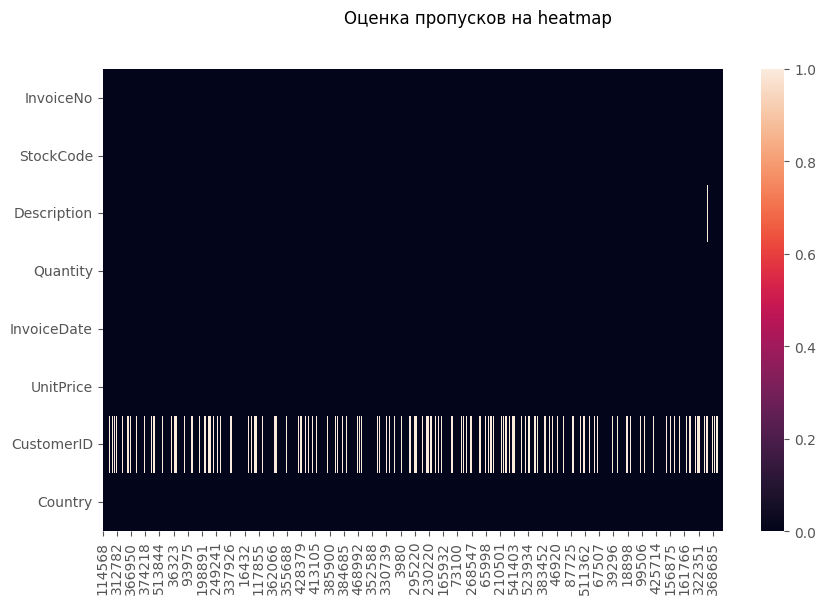



Проверка на дубликаты
Количество полных дубликатов:
 5268

Первые 10 строк датасета


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom



Описание количественных данных:


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Quantity,541909.0,NaN,NaT,NaN,NaT,NaT,9.55225,218.081158,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaT,NaN,NaT,NaT,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaT,NaN,NaT,NaT,15287.69057,1713.600303,12346.0,13953.0,15152.0,16791.0,18287.0



Графическое представление количественных данных:


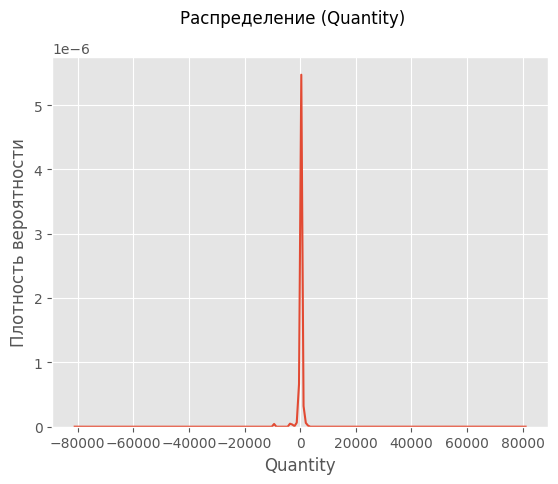

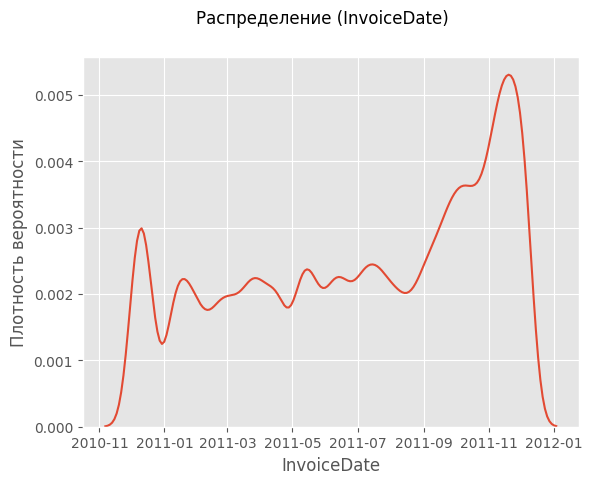

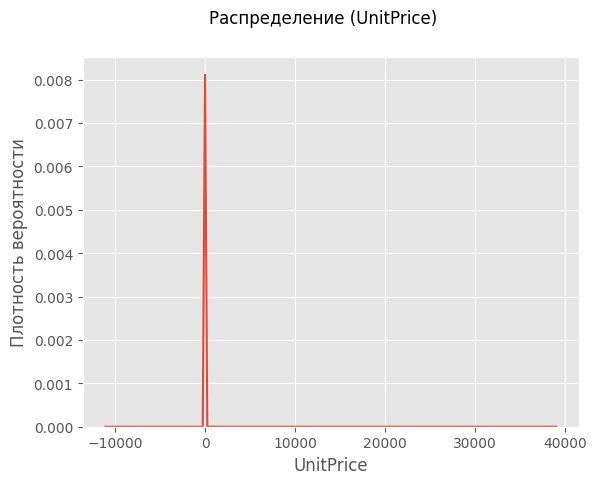

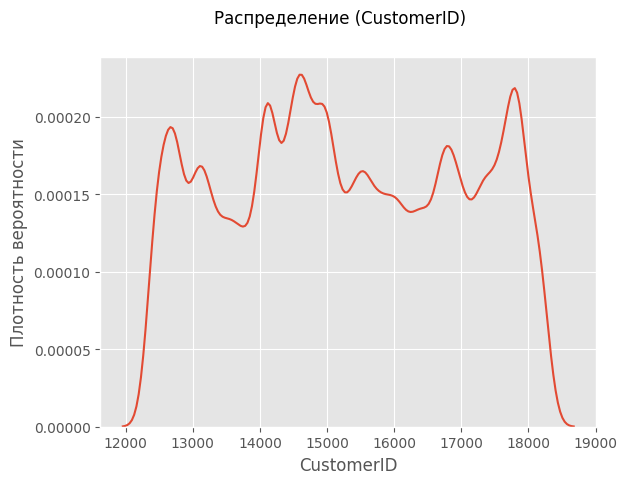



Описание категориальных данных:


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4221,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478



Графическое представление категориальных данных:


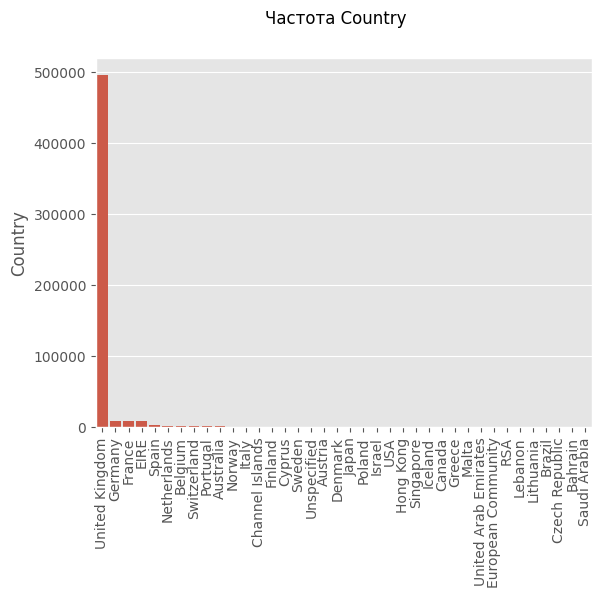



Описание категориальных данных:


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4221,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478



Вывод уникальных значений по каждому признаку:
InvoiceNo


C558901       1
563934        1
536866        1
C559417       1
559414        1
           ... 
558475      705
580729      721
581492      731
581219      749
573585     1114
Name: InvoiceNo, Length: 25900, dtype: int64

StockCode


72759        1
84971l       1
90183c       1
85034b       1
90184c       1
          ... 
20725     1639
47566     1727
85099B    2159
22423     2203
85123A    2313
Name: StockCode, Length: 4070, dtype: int64

Description


WRAP BLUE RUSSIAN FOLKART                 1
CHRISTMAS CRAFT HEART STOCKING            1
dotcom sales                              1
SET 10 CARDS CHRISTMAS BAUBLE 16954       1
ANT SILVER TURQUOISE BOUDICCA RING        1
                                       ... 
LUNCH BAG RED RETROSPOT                1638
PARTY BUNTING                          1727
JUMBO BAG RED RETROSPOT                2159
REGENCY CAKESTAND 3 TIER               2200
WHITE HANGING HEART T-LIGHT HOLDER     2369
Name: Description, Length: 4221, dtype: int64

Quantity


-80995         1
 1020          1
 234           1
 148           1
-696           1
           ...  
 4         38484
 6         40868
 12        61063
 2         81829
 1        148227
Name: Quantity, Length: 722, dtype: int64

InvoiceDate


2011-03-16 15:58:00       1
2011-04-08 17:08:00       1
2011-08-28 10:54:00       1
2011-04-08 17:07:00       1
2011-08-26 14:20:00       1
                       ... 
2011-06-29 15:58:00     705
2011-12-05 17:24:00     721
2011-12-09 10:03:00     731
2011-12-08 09:28:00     749
2011-10-31 14:41:00    1114
Name: InvoiceDate, Length: 23260, dtype: int64

UnitPrice


2114.00        1
164.46         1
208.12         1
166.92         1
212.04         1
           ...  
0.42       24533
2.95       27768
0.85       28497
1.65       38181
1.25       50496
Name: UnitPrice, Length: 1630, dtype: int64

CustomerID


16995.0       1
18233.0       1
15316.0       1
14679.0       1
14705.0       1
           ... 
14606.0    2782
12748.0    4642
14096.0    5128
14911.0    5903
17841.0    7983
Name: CustomerID, Length: 4372, dtype: int64

Country


Saudi Arabia                10
Bahrain                     19
Czech Republic              30
Brazil                      32
Lithuania                   35
Lebanon                     45
RSA                         58
European Community          61
United Arab Emirates        68
Malta                      127
Greece                     146
Canada                     151
Iceland                    182
Singapore                  229
Hong Kong                  288
USA                        291
Israel                     297
Poland                     341
Japan                      358
Denmark                    389
Austria                    401
Unspecified                446
Sweden                     462
Cyprus                     622
Finland                    695
Channel Islands            758
Italy                      803
Norway                    1086
Australia                 1259
Portugal                  1519
Switzerland               2002
Belgium                   2069
Netherla

In [7]:
check_data(df)

Сегментировать покупки, id клиентов которых неизвестен, не получится. Выбросим их из рассмотрения df. Пропуски в description нам не помешают. Также удалим полные дубликаты, так как это очевидная ошибка.

In [8]:
df = df[(df['CustomerID'].notnull()) & (~df.duplicated())]
df['CustomerID'] = df['CustomerID'].astype(int)

# 2. Сегментирование пользователей

## 2.1 Подготовка перед расчётами

Ещё посмотрим на распределение уникальных покупателей по странам.

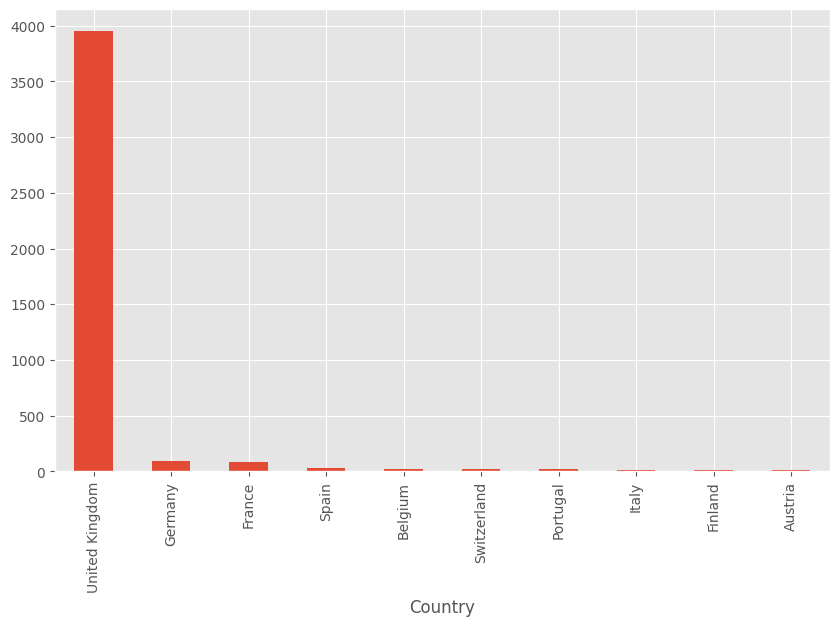

In [9]:
g = (
    df.groupby('Country')['CustomerID']
    .agg('nunique')
    .sort_values(ascending=False)[:10]
    .plot(figsize=(10, 6), kind='bar')
)

g;

Будем работать с Великобританией, так как большинство уникальных пользователей находятся именно там. Остальные пользователи из других стран увидели наш сайт случайно, но они тоже могут приносить нам деньги, поэтому мы переобозначим их страны в одну категорию 'Others'.

In [10]:
df['Country'] = (
    df['Country']
    .apply(lambda x: 'Others' if x != 'United Kingdom' else x)
)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0
CustomerID,401604.0,15281.160818,1714.006089,12346.0,13939.00,15145.00,16784.00,18287.0


In [12]:
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Из описания данных видно, что некоторые заказы были отменены, а на некоторые была применена скидка. По сути нам важно, чтобы заказ покупателя не выходил в 0. Если на заказ была применена скидка, то стоимость заказа всё равно какая-то будет, а если покупатель полностью отменил заказ, то этот заказ выбросим.

In [13]:
t = df.copy()

In [14]:
# Колонка с итоговой суммой потраченной при покупке товаров в заказе
t['TotalPrice'] = t['Quantity'] * t['UnitPrice']

In [15]:
# Создадим общую таблицу с суммой всего заказа пользователя. По ней и будем ориентироваться

t = (
    t
    .groupby(['CustomerID', 'InvoiceNo'])
    .agg({'TotalPrice': 'sum',
          'InvoiceDate': 'min',
          'StockCode': lambda x: (x == 'D').any()})
    .reset_index()
)

t.head()

,CustomerID,InvoiceNo,TotalPrice,InvoiceDate,StockCode
0,12346,541431,77183.60,2011-01-18 10:01:00,False
1,12346,C541433,-77183.60,2011-01-18 10:17:00,False
2,12347,537626,711.79,2010-12-07 14:57:00,False
3,12347,542237,475.39,2011-01-26 14:30:00,False
4,12347,549222,636.25,2011-04-07 10:43:00,False


In [16]:
t['InvoiceDate'].min(), t['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [17]:
PRESENT = dt.datetime(2011, 12, 10)  # Самая новая дата

## 2.2 RFM-анализ

In [18]:
rfm = (
    t.groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (PRESENT - x.max()).days,
        'InvoiceNo': lambda x: x.count() - x.str.startswith('C').sum(),
        'TotalPrice': lambda x: x.sum()
    })
)

rfm['InvoiceNo'] = rfm['InvoiceNo'] + t.groupby('CustomerID')['StockCode'].sum()
rfm = rfm.rename(columns={
    'InvoiceNo': 'frequency',
    'InvoiceDate': 'recency',
    'TotalPrice': 'monetary'
    }).reset_index()

coutry = df.groupby('CustomerID')['Country'].agg(lambda x: x.mode()).reset_index()
rfm = rfm.merge(coutry, how='inner', on='CustomerID').set_index('CustomerID')

In [19]:
rfm.tail()

,recency,frequency,monetary,Country
CustomerID,,,,
18280,277,1,180.60,United Kingdom
18281,180,1,80.82,United Kingdom
18282,7,2,176.60,United Kingdom
18283,3,16,2045.53,United Kingdom
18287,42,3,1837.28,United Kingdom


In [20]:
rfm['monetary'].sum()

8278519.424

Посмотрим на то, как распределены наши характеристики, которые мы построили для сегментации.

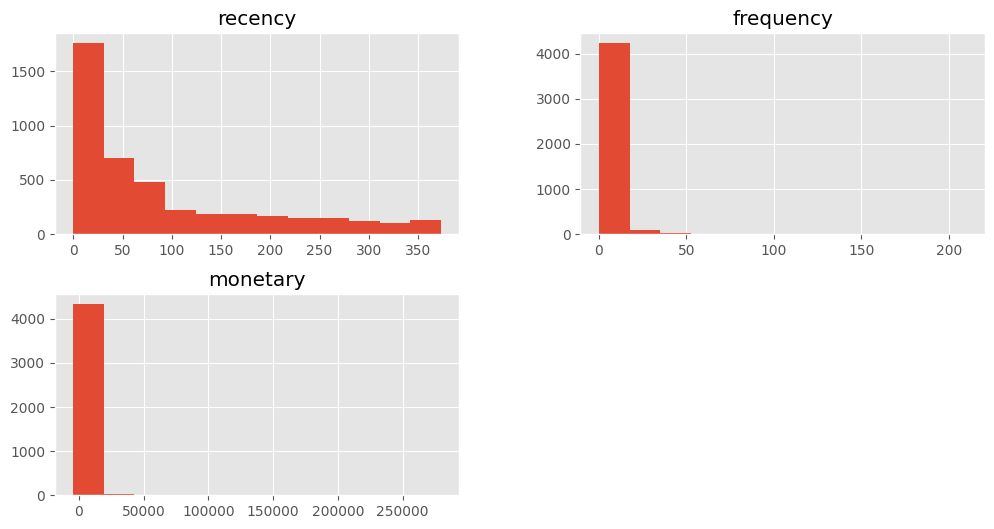

In [21]:
rfm[['recency', 'frequency', 'monetary']].hist(figsize=(12, 6), bins=12);

Прологарифмируем наши характеристики, чтобы визуализация казалась более информативной.

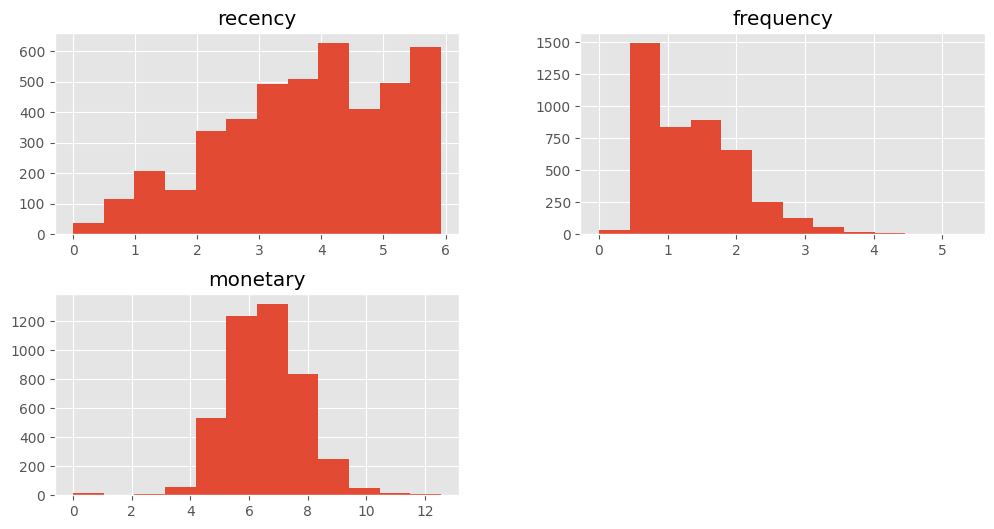

In [22]:
g = (
    rfm[['recency', 'frequency', 'monetary']]
    .apply(lambda x: np.log(x + 1))
    .hist(figsize=(12, 6), bins=12)
)

g;

Для сегментации будут использоваться квартили, поэтому выбросы в данных очищать не будем, так как квартили к выбросам устойчивы. Однако в будущем мы отрисуем картинки, поэтому характеристики мы прологарифмируем в таблице.

In [23]:
rfm[['recency_log', 'frequency_log', 'monetary_log']] = (
    rfm[['recency', 'frequency', 'monetary']]
    .apply(lambda x: np.log(x + 1))
)

In [24]:
rfm['r_quantile'] = pd.qcut(rfm['recency'], 4, ['1', '2', '3', '4'])
rfm['f_quantile'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, ['4', '3', '2', '1'])
rfm['m_quantile'] = pd.qcut(rfm['monetary'], 4, ['4', '3', '2', '1'])

Создадим единую колонку с номерами сегментов.

In [25]:
rfm['rfm_score'] = rfm['r_quantile'].astype(str) + rfm['f_quantile'].astype(str) + rfm['m_quantile'].astype(str)

In [26]:
rfm.head()

,recency,frequency,monetary,Country,recency_log,frequency_log,monetary_log,r_quantile,f_quantile,m_quantile,rfm_score
CustomerID,,,,,,,,,,,
12346,325,1,0.00,United Kingdom,5.786897,0.693147,0.000000,4,4,4,444
12347,2,7,4310.00,Others,1.098612,2.079442,8.368925,1,1,1,111
12348,75,4,1797.24,Others,4.330733,1.609438,7.494564,3,2,1,321
12349,18,1,1757.55,Others,2.944439,0.693147,7.472245,2,4,1,241
12350,310,1,334.40,Others,5.739793,0.693147,5.815324,4,4,3,443


Больше всего нас интересует категория '111', меньше всего - '444'.

In [27]:
rfm.shape

(4372, 11)

### 2.2.1 Проверка гипотез

Выберем только самых преданных покупателей. При этом разобьём трафик по стране.

In [28]:
top_uk = (rfm[(rfm['rfm_score'] == '111') & (rfm['Country'] == 'United Kingdom')]
          .sort_values('monetary', ascending=False)
          .head(20)
)

top_uk

,recency,frequency,monetary,Country,recency_log,frequency_log,monetary_log,r_quantile,f_quantile,m_quantile,rfm_score
CustomerID,,,,,,,,,,,
18102,0,60,256438.49,United Kingdom,0.000000,4.110874,12.454648,1,1,1,111
17450,8,47,187322.17,United Kingdom,2.197225,3.871201,12.140591,1,1,1,111
17511,2,31,88125.38,United Kingdom,1.098612,3.465736,11.386527,1,1,1,111
16684,4,29,65892.08,United Kingdom,1.609438,3.401197,11.095789,1,1,1,111
13694,3,52,62690.54,United Kingdom,1.386294,3.970292,11.045982,1,1,1,111
15311,0,91,59284.19,United Kingdom,0.000000,4.521789,10.990115,1,1,1,111
13089,2,97,57322.13,United Kingdom,1.098612,4.584967,10.956459,1,1,1,111
14096,4,17,57120.91,United Kingdom,1.609438,2.890372,10.952943,1,1,1,111
15061,3,48,54228.74,United Kingdom,1.386294,3.891820,10.900985,1,1,1,111


In [29]:
top_others = (rfm[(rfm['rfm_score'] == '111') & (rfm['Country'] == 'Others')]
          .sort_values('monetary', ascending=False)
          .head(20)
)

top_others

,recency,frequency,monetary,Country,recency_log,frequency_log,monetary_log,r_quantile,f_quantile,m_quantile,rfm_score
CustomerID,,,,,,,,,,,
14646,1,75,279489.02,Others,0.693147,4.330733,12.540722,1,1,1,111
14911,1,202,132458.73,Others,0.693147,5.313206,11.794034,1,1,1,111
14156,9,55,113214.59,Others,2.302585,4.025352,11.637049,1,1,1,111
17404,4,15,30300.82,Others,1.609438,2.772589,10.318963,1,1,1,111
12753,3,6,21024.01,Others,1.386294,1.945910,9.953468,1,1,1,111
12471,2,30,18705.52,Others,1.098612,3.433987,9.836627,1,1,1,111
12681,14,22,13677.59,Others,2.708050,3.135494,9.523587,1,1,1,111
12621,1,20,13612.07,Others,0.693147,3.044522,9.518786,1,1,1,111
12433,0,7,13375.87,Others,0.000000,2.079442,9.501282,1,1,1,111


Теперь представим ситуацию, что к нам пришёл менеджер и попросил выяснить; H0: топ покупателей из других стран и из UK в среднем одинаково тратят, а H1: тратят в среднем разное количество денег. Создадим функцию подсчёта методом Стьютента, если выборки имеют распределение похожее на нормальное, или Манн-Уитни - в обратном случае.

In [30]:
num_digits = 4
def numeric_hypothesis_test(sample_1, sample_2) -> Tuple[float, str]:
  '''Функция для проверки статистических гипотез на 2 группах'''
  if len(sample_1) < 3 or len(sample_2) < 3:
    return np.nan, np.nan

  if shapiro(sample_1)[1] >= 0.05 and shapiro(sample_2)[1] >= 0.05:
      method = 'Стьюдент'
      p_value = ttest_ind(sample_1, sample_2, equal_var=False)[1]
  else:
      method = 'Манн-Уитни'
      p_value = mannwhitneyu(sample_1, sample_2, alternative='two-sided')[1]

  if p_value > 0:
    order = math.floor(math.log10(abs(p_value))) + 1
    p_value = round(p_value, num_digits - order)
  return p_value, method

In [31]:
# Возьму логорифм monetary, так как есть большие выбросы в значениях
numeric_hypothesis_test(top_uk['monetary_log'], top_others['monetary_log'])

(0.0001294, 'Манн-Уитни')

p-value сильно меньше, чем 0.05. Значит, вероятность того, что получить выборки с такими средними или более выраженными (что в одну, что в другую сторону) случайно составляет значение равное p-value. Отсюда делаем вывод, что выборки пришли из разных распределений. Принимаем альтернативную гипотезу о различии средних.

### 2.2.2 Визуализация RFM-score

Отобразим наиболее значимые по количеству кластеры в пространстве.

In [32]:
rfm['rfm_score'].value_counts().sort_values(ascending=False)[:10]

111    482
444    321
211    229
434    180
222    178
443    164
322    153
433    141
344    141
122    130
Name: rfm_score, dtype: int64

In [33]:
clusters = rfm['rfm_score'].value_counts()
big_clusters = clusters[clusters > 100].index.values
big_clusters

array(['111', '444', '211', '434', '222', '443', '322', '433', '344',
       '122', '333', '343', '112'], dtype=object)

In [34]:
import plotly.express as ex

ex.scatter_3d(
    rfm[rfm['rfm_score'].isin(big_clusters)],
    x='recency_log',
    y='frequency_log',
    z='monetary_log',
    color='rfm_score'
)

Из этих кластеров рассмотрю на распределении те, где кластеры имеют хорошую или выше среднего оценку rfm-score. Рассмотрю их по проскостям.

In [35]:
significant_clusters = ['111', '122', '211', '222', '112']

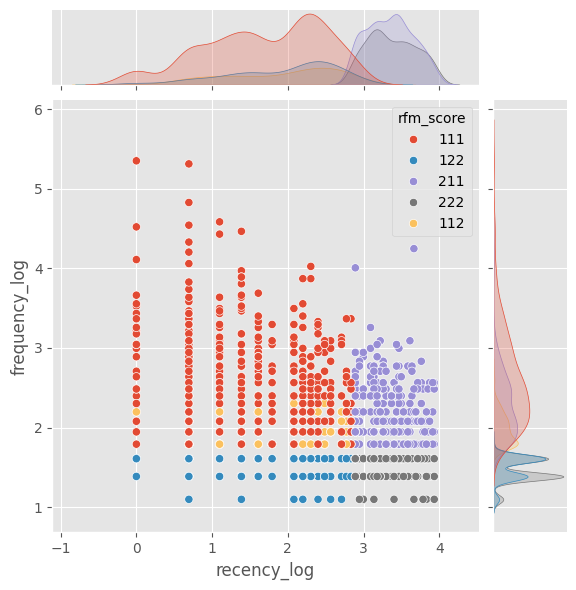

In [36]:
g = sns.jointplot(
    rfm[rfm['rfm_score'].isin(significant_clusters)],
    x='recency_log',
    y='frequency_log',
    hue='rfm_score'
)

g;

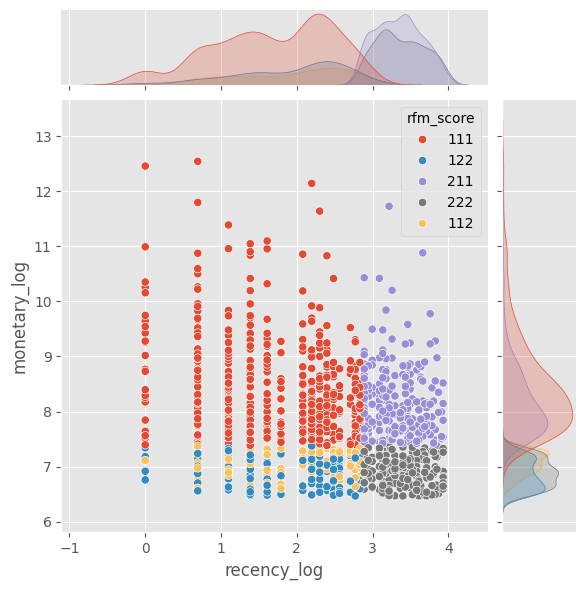

In [37]:
g = sns.jointplot(
    rfm[rfm['rfm_score'].isin(significant_clusters)],
    x='recency_log',
    y='monetary_log',
    hue='rfm_score'
)

g;

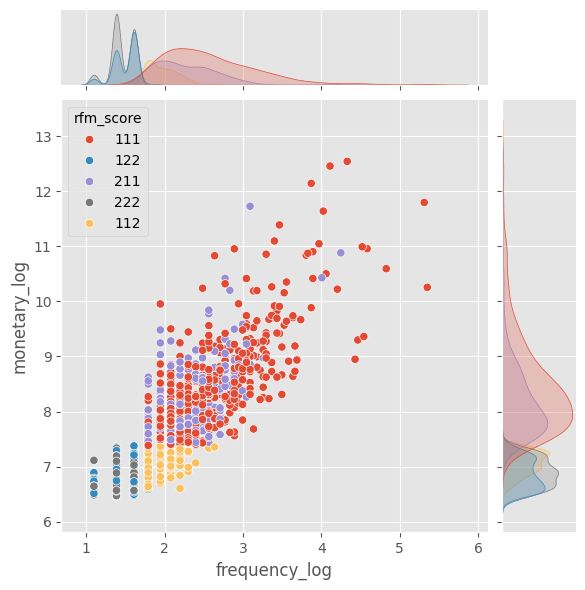

In [38]:
g = sns.jointplot(
    rfm[rfm['rfm_score'].isin(significant_clusters)],
    x='frequency_log',
    y='monetary_log',
    hue='rfm_score'
)

g;

# 3. Продуктовые метрики

## 3.1 Подготовка перед расчётами

### 3.1.1 Таблица с уникальными пользователями

В реальной жизни такая таблица обычно имеется сразу и можно ей пользоваться.

In [39]:
users = df.groupby(['CustomerID'])['InvoiceDate'].min().reset_index()
users.columns = ['CustomerID', 'reg_date']
users.head()

,CustomerID,reg_date
0,12346,2011-01-18 10:01:00
1,12347,2010-12-07 14:57:00
2,12348,2010-12-16 19:09:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [40]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')
users.head()

,CustomerID,reg_date,reg_month
0,12346,2011-01-18 10:01:00,2011-01-01
1,12347,2010-12-07 14:57:00,2010-12-01
2,12348,2010-12-16 19:09:00,2010-12-01
3,12349,2011-11-21 09:51:00,2011-11-01
4,12350,2011-02-02 16:01:00,2011-02-01


Сгенерируем таблицу, где на каждого юзера будет каждый месяц.

In [41]:
min_month = df['InvoiceDate'].values.astype('datetime64[M]').min()
max_month = df['InvoiceDate'].values.astype('datetime64[M]').max()
(min_month, max_month)

(numpy.datetime64('2010-12'), numpy.datetime64('2011-12'))

In [42]:
dr = pd.DataFrame(pd.date_range(min_month, max_month, freq='MS'))
dr.columns = ['month']
dr.head()

,month
0,2010-12-01
1,2011-01-01
2,2011-02-01
3,2011-03-01
4,2011-04-01


Теперь надо сделать кросcджоин. Должно получиться

In [43]:
len(users) * len(dr)

56836

строк. В пандас кросcджоин делается так:

In [44]:
dr['key'] = 1
users['key'] = 1

In [45]:
rep = dr.merge(users, on='key')
rep.shape

(56836, 5)

Как и ожидали, но у нас есть пользователи, которые пришли после минимальной даты (2010-12) и глупо хранить по ним строчки за тот период, пока их с нами не было.

In [46]:
rep = rep[rep['month'] >= rep['reg_month']]

In [47]:
len(rep)

37436

Глянем на отдельного пользователя.

In [48]:
rep[rep['CustomerID'] == 12346]

,month,key,CustomerID,reg_date,reg_month
4372,2011-01-01,1,12346,2011-01-18 10:01:00,2011-01-01
8744,2011-02-01,1,12346,2011-01-18 10:01:00,2011-01-01
13116,2011-03-01,1,12346,2011-01-18 10:01:00,2011-01-01
17488,2011-04-01,1,12346,2011-01-18 10:01:00,2011-01-01
21860,2011-05-01,1,12346,2011-01-18 10:01:00,2011-01-01
26232,2011-06-01,1,12346,2011-01-18 10:01:00,2011-01-01
30604,2011-07-01,1,12346,2011-01-18 10:01:00,2011-01-01
34976,2011-08-01,1,12346,2011-01-18 10:01:00,2011-01-01
39348,2011-09-01,1,12346,2011-01-18 10:01:00,2011-01-01
43720,2011-10-01,1,12346,2011-01-18 10:01:00,2011-01-01


Теперь можно джойнить инфу по продажам.

### 3.1.2 Группировка данных по продажам

Посчитаем суммарные продажи на каждый месяц.

In [49]:
t = df.copy()
t['month'] = t['InvoiceDate'].values.astype('datetime64[M]')
t['revenue'] = t['UnitPrice'] * t['Quantity']

In [50]:
sales_month = (
    t.groupby(['CustomerID', 'month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

sales_month.head()

,CustomerID,month,revenue
0,12346,2011-01-01,0.00
1,12347,2010-12-01,711.79
2,12347,2011-01-01,475.39
3,12347,2011-04-01,636.25
4,12347,2011-06-01,382.52


Обязательно проверим контрольную сумму.

In [51]:
round(t['revenue'].sum(), 4), round(sales_month['revenue'].sum(), 4)

(8278519.424, 8278519.424)

In [52]:
del(t)

### 3.1.3 Объединение таблиц

In [53]:
report = rep.merge(sales_month, how='left', on=['CustomerID', 'month'])
report = report.drop(columns=['key'])
report['revenue'] = report['revenue'].fillna(0)
country = df.groupby('CustomerID')['Country'].agg(lambda x: x.mode()).reset_index()
report = report.merge(country, how='inner', on='CustomerID')
report.head()

,month,CustomerID,reg_date,reg_month,revenue,Country
0,2010-12-01,12347,2010-12-07 14:57:00,2010-12-01,711.79,Others
1,2011-01-01,12347,2010-12-07 14:57:00,2010-12-01,475.39,Others
2,2011-02-01,12347,2010-12-07 14:57:00,2010-12-01,0.00,Others
3,2011-03-01,12347,2010-12-07 14:57:00,2010-12-01,0.00,Others
4,2011-04-01,12347,2010-12-07 14:57:00,2010-12-01,636.25,Others


Добавим флаг юзера, нового юзера, и активного юзера.

In [54]:
report['user'] = 1
report['new_user'] = (report['reg_month'] == report['month']) * 1
report['active'] = (report['revenue'] > 0) * 1
report.head()

,month,CustomerID,reg_date,reg_month,revenue,Country,user,new_user,active
0,2010-12-01,12347,2010-12-07 14:57:00,2010-12-01,711.79,Others,1,1,1
1,2011-01-01,12347,2010-12-07 14:57:00,2010-12-01,475.39,Others,1,0,1
2,2011-02-01,12347,2010-12-07 14:57:00,2010-12-01,0.00,Others,1,0,0
3,2011-03-01,12347,2010-12-07 14:57:00,2010-12-01,0.00,Others,1,0,0
4,2011-04-01,12347,2010-12-07 14:57:00,2010-12-01,636.25,Others,1,0,1


## 3.2 Расчёт метрик

In [55]:
metrics = (report
     .groupby(['month', 'Country'], dropna=False)[['revenue', 'user', 'new_user', 'active']]
     .agg('sum')
)
metrics

revenue  user  new_user  active
month      Country                                           
2010-12-01 Others           70697.630    77        77      69
           United Kingdom  481675.230   871       871     812
2011-01-01 Others          123063.100   136        59      94
           United Kingdom  350668.800  1233       362     642
2011-02-01 Others           87677.520   177        41      78
           United Kingdom  347856.550  1572       339     675
2011-03-01 Others          123042.140   209        32      91
           United Kingdom  455534.070  1980       408     877
2011-04-01 Others           49303.440   232        23      70
           United Kingdom  375919.231  2256       276     780
2011-05-01 Others          122647.790   259        27      93
           United Kingdom  524363.880  2508       252     959
2011-06-01 Others          135476.160   287        28     101
           United Kingdom  471386.360  2715       207     885
2011-07-01 Others          113029.430   306        19      90
           United Kingdom  460082.891  2887       172     853
2011-08-01 Others          139325.140   333        27     100
           United Kingdom  475752.950  3027       140     830
2011-09-01 Others          154735.930   356        23     120
           United Kingdom  774620.302  3302       275    1140
2011-10-01 Others          191695.460   390        34     133
           United Kingdom  781610.920  3620       318    1223
2011-11-01 Others          176083.620   415        25     159
           United Kingdom  950731.450  3916       296    1499
2011-12-01 Others           44585.910   422         7      54
           United Kingdom  296953.520  3950        34     557

Количество новых пользователей соответствует количеству уникальных пользователей.

In [56]:
metrics['new_user'].sum(), len(df['CustomerID'].unique())

(4372, 4372)

Рассчитаем метрики.

In [57]:
# коэффициент активации
metrics['activation_rate'] = round(metrics['new_user'] / metrics['user'], 4)
# коэффициент удержания, доли
metrics['retention_rate'] = round((metrics['active'] - metrics['new_user']) / (metrics['user'] - metrics['new_user']), 4)
metrics.loc[metrics['retention_rate'].abs() == float('inf'), 'retention_rate'] = None
# cредний доход с активного пользователя за месяц
metrics['arpau'] = round(metrics['revenue'] / metrics['active'], 2)
# средний доход с нового пользователя за месяц
metrics['arpn'] = round(metrics['revenue'] / metrics['new_user'], 2)
# коэффициент роста пользовательской базы за месяц, доли
metrics['agr'] = round((metrics['user'] / (metrics['user'] - metrics['new_user'])) - 1, 4)
metrics.loc[metrics['agr'] == float('inf'), 'agr'] = None

In [58]:
metrics

revenue  user  new_user  active  \
month      Country                                              
2010-12-01 Others           70697.630    77        77      69   
           United Kingdom  481675.230   871       871     812   
2011-01-01 Others          123063.100   136        59      94   
           United Kingdom  350668.800  1233       362     642   
2011-02-01 Others           87677.520   177        41      78   
           United Kingdom  347856.550  1572       339     675   
2011-03-01 Others          123042.140   209        32      91   
           United Kingdom  455534.070  1980       408     877   
2011-04-01 Others           49303.440   232        23      70   
           United Kingdom  375919.231  2256       276     780   
2011-05-01 Others          122647.790   259        27      93   
           United Kingdom  524363.880  2508       252     959   
2011-06-01 Others          135476.160   287        28     101   
           United Kingdom  471386.360  2715       207     885   
2011-07-01 Others          113029.430   306        19      90   
           United Kingdom  460082.891  2887       172     853   
2011-08-01 Others          139325.140   333        27     100   
           United Kingdom  475752.950  3027       140     830   
2011-09-01 Others          154735.930   356        23     120   
           United Kingdom  774620.302  3302       275    1140   
2011-10-01 Others          191695.460   390        34     133   
           United Kingdom  781610.920  3620       318    1223   
2011-11-01 Others          176083.620   415        25     159   
           United Kingdom  950731.450  3916       296    1499   
2011-12-01 Others           44585.910   422         7      54   
           United Kingdom  296953.520  3950        34     557   

                           activation_rate  retention_rate    arpau     arpn  \
month      Country                                                             
2010-12-01 Others                   1.0000             NaN  1024.60   918.15   
           United Kingdom           1.0000             NaN   593.20   553.01   
2011-01-01 Others                   0.4338          0.4545  1309.18  2085.82   
           United Kingdom           0.2936          0.3215   546.21   968.70   
2011-02-01 Others                   0.2316          0.2721  1124.07  2138.48   
           United Kingdom           0.2156          0.2725   515.34  1026.13   
2011-03-01 Others                   0.1531          0.3333  1352.11  3845.07   
           United Kingdom           0.2061          0.2983   519.42  1116.51   
2011-04-01 Others                   0.0991          0.2249   704.33  2143.63   
           United Kingdom           0.1223          0.2545   481.95  1362.03   
2011-05-01 Others                   0.1042          0.2845  1318.79  4542.51   
           United Kingdom           0.1005          0.3134   546.78  2080.81   
2011-06-01 Others                   0.0976          0.2819  1341.35  4838.43   
           United Kingdom           0.0762          0.2703   532.64  2277.23   
2011-07-01 Others                   0.0621          0.2474  1255.88  5948.92   
           United Kingdom           0.0596          0.2508   539.37  2674.90   
2011-08-01 Others                   0.0811          0.2386  1393.25  5160.19   
           United Kingdom           0.0463          0.2390   573.20  3398.24   
2011-09-01 Others                   0.0646          0.2913  1289.47  6727.65   
           United Kingdom           0.0833          0.2858   679.49  2816.80   
2011-10-01 Others                   0.0872          0.2781  1441.32  5638.10   
           United Kingdom           0.0878          0.2741   639.09  2457.90   
2011-11-01 Others                   0.0602          0.3436  1107.44  7043.34   
           United Kingdom           0.0756          0.3323   634.24  3211.93   
2011-12-01 Others                   0.0166          0.1133   825.67  6369.42   
           United Kingdom           0.0086       

### 3.2.1 Визуализация метрик

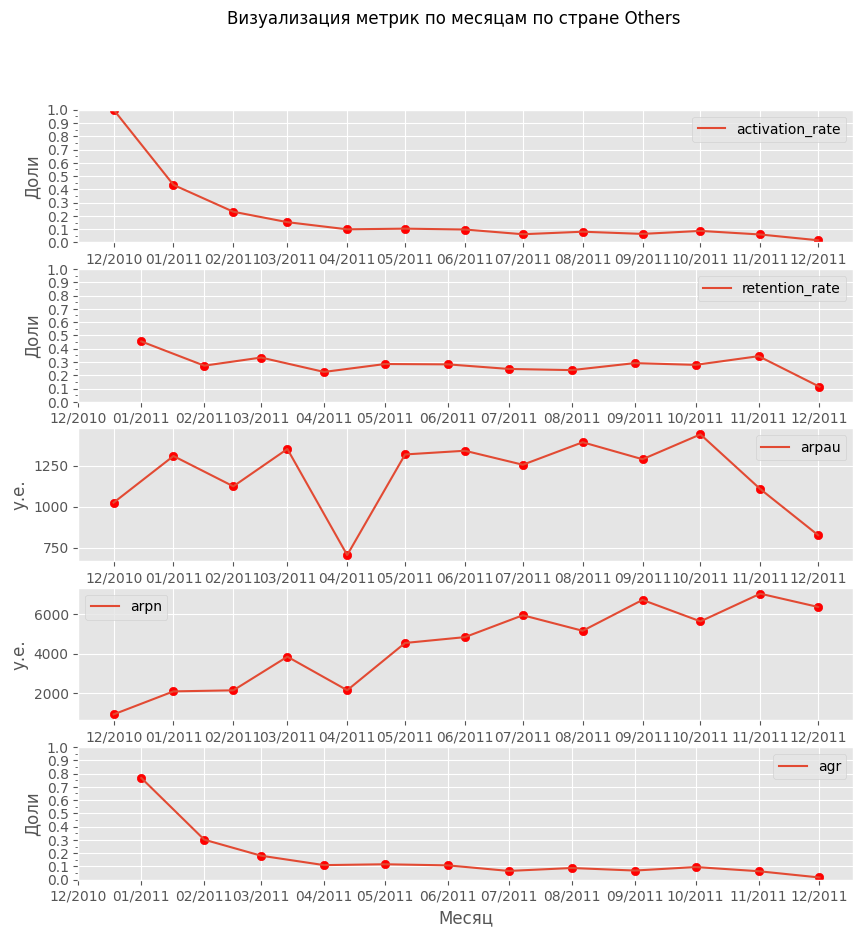

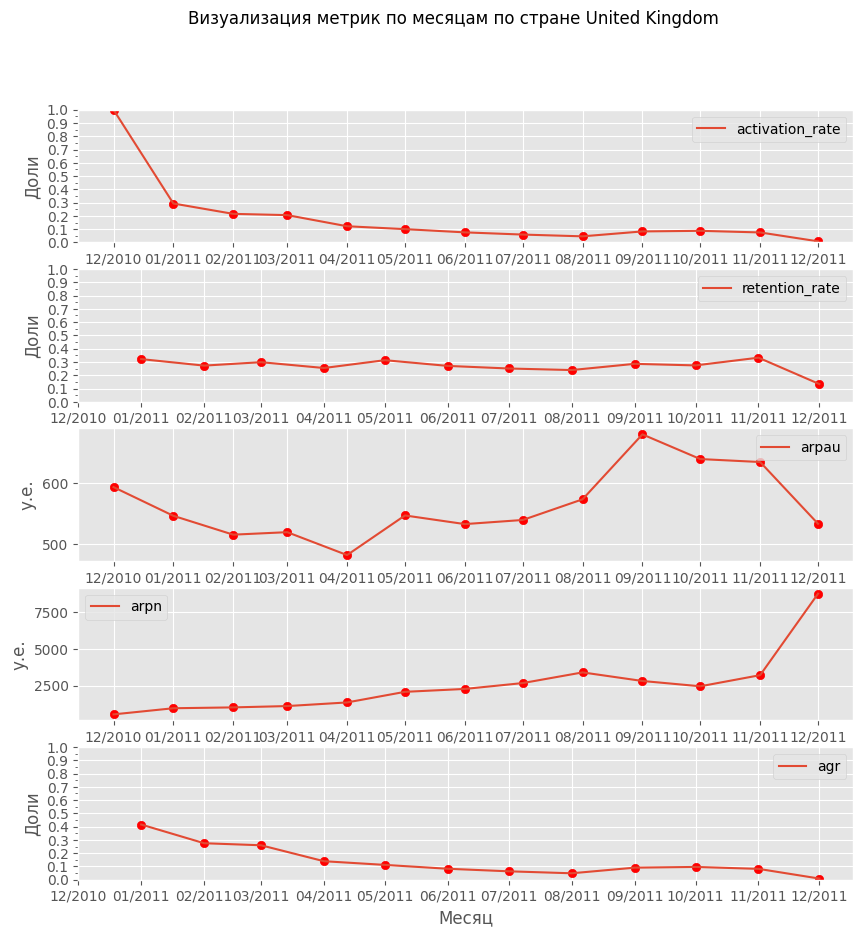

In [59]:
t = metrics.reset_index()
t = t.set_index('month')

for c in t['Country'].unique():
  g = t[t['Country'] == c]
  fig, ax = plt.subplots(5, 1, figsize=(10, 10))

  ax[0].plot(g.index, g['activation_rate'], label='activation_rate')
  ax[0].scatter(g.index, g['activation_rate'], color='red')
  ax[0].set_xlabel('Месяц')
  ax[0].set_ylabel('Доли')
  ax[0].set_xticks(g.index.values)
  ax[0].set_xticklabels(pd.to_datetime(g.index).strftime('%m/%Y'))
  ax[0].set_ylim((0, 1))
  ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
  ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
  ax[0].legend()

  ax[1].plot(g.index, g['retention_rate'], label='retention_rate')
  ax[1].scatter(g.index, g['retention_rate'], color='red')
  ax[1].set_xlabel('Месяц')
  ax[1].set_ylabel('Доли')
  ax[1].set_xticks(g.index.values)
  ax[1].set_xticklabels(pd.to_datetime(g.index).strftime('%m/%Y'))
  ax[1].set_ylim((0, 1))
  ax[1].yaxis.set_major_locator(MultipleLocator(0.1))
  ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
  ax[1].legend()

  ax[2].plot(g.index, g['arpau'], label='arpau')
  ax[2].scatter(g.index, g['arpau'], color='red')
  ax[2].set_xlabel('Месяц')
  ax[2].set_ylabel('у.е.')
  ax[2].set_xticks(g.index.values)
  ax[2].set_xticklabels(pd.to_datetime(g.index).strftime('%m/%Y'))
  ax[2].legend()

  ax[3].plot(g.index, g['arpn'], label='arpn')
  ax[3].scatter(g.index, g['arpn'], color='red')
  ax[3].set_xlabel('Месяц')
  ax[3].set_ylabel('у.е.')
  ax[3].set_xticks(g.index.values)
  ax[3].set_xticklabels(pd.to_datetime(g.index).strftime('%m/%Y'))
  ax[3].legend()

  ax[4].plot(g.index, g['agr'], label='agr')
  ax[4].scatter(g.index, g['agr'], color='red')
  ax[4].set_xlabel('Месяц')
  ax[4].set_ylabel('Доли')
  ax[4].set_xticks(g.index.values)
  ax[4].set_xticklabels(pd.to_datetime(g.index).strftime('%m/%Y'))
  ax[4].set_ylim((0, 1))
  ax[4].yaxis.set_major_locator(MultipleLocator(0.1))
  ax[4].yaxis.set_minor_locator(MultipleLocator(0.05))
  ax[4].legend()

  plt.suptitle(f'Визуализация метрик по месяцам по стране {c}')
  plt.show();

### 3.2.2 Период удержания пользователей

Выясним, retention пользователей по разным периодам.

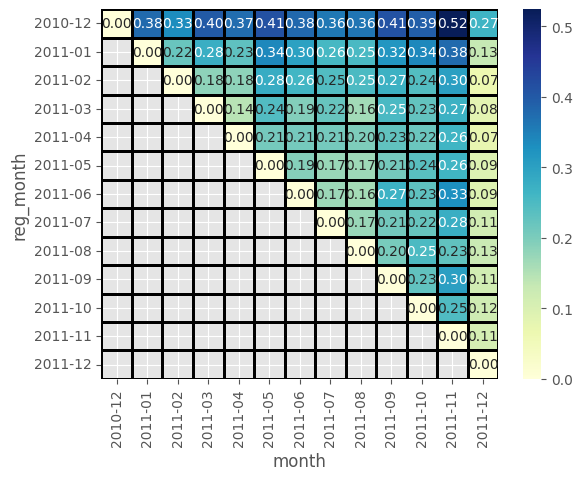

In [60]:
copy = (report
        .groupby(['month', 'reg_month'])
        .agg({'active': 'sum'})
        .reset_index())
copy = copy.sort_values(by=['reg_month', 'month'])

copy['retention_rate'] = ((copy
                           .groupby('reg_month')['active']
                           .transform(lambda x: x)) /
                            (copy
                             .groupby('reg_month')['active']
                             .transform('first'))
)
copy.loc[copy['retention_rate'] == 1, 'retention_rate'] = 0
copy = copy.reset_index()
copy['month'] = copy['month'].apply(lambda x: x.strftime('%Y-%m'))
copy['reg_month'] = copy['reg_month'].apply(lambda x: x.strftime('%Y-%m'))

retention_uk = (
    copy.pivot_table(
        index='reg_month',
        columns='month',
        values='retention_rate'
    )
)

sns.heatmap(
    retention_uk,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='black',
    cmap='YlGnBu'
);

**Вывод:** хороший показатель retention удерживается для пользователей, которые были с нами с самого начала (с 2010/12).

# 4. Работа с сезонностью временного ряда

In [61]:
all_days = pd.DataFrame(
    pd.date_range(df['InvoiceDate'].min(), df['InvoiceDate'].max(), freq='D'),
    columns=['date']
)
all_days['date'] = all_days['date'].values.astype('datetime64[D]')
copy = df.copy()
copy['date'] = copy['InvoiceDate'].values.astype('datetime64[D]')
all_days = all_days.merge(copy, how='left', on='date')
del(copy)
all_days

,date,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,2010-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,2010-12-01,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2010-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,2010-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,2010-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
401668,2011-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-12-09 12:50:00,0.85,12680.0,Others
401669,2011-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680.0,Others
401670,2011-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680.0,Others
401671,2011-12-09,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680.0,Others


In [62]:
st = (all_days
      .groupby('date')['CustomerID']
      .nunique()
      .reset_index()
      .rename(columns={'CustomerID': 'user_activity'})
)
st['month'] = st['date'].apply(lambda x: x.strftime('%Y-%m'))
st['weekday'] = st['date'].dt.weekday
st

,date,user_activity,month,weekday
0,2010-12-01,98,2010-12,2
1,2010-12-02,117,2010-12,3
2,2010-12-03,55,2010-12,4
3,2010-12-04,0,2010-12,5
4,2010-12-05,76,2010-12,6
...,...,...,...,...
369,2011-12-05,114,2011-12,0
370,2011-12-06,128,2011-12,1
371,2011-12-07,101,2011-12,2
372,2011-12-08,120,2011-12,3


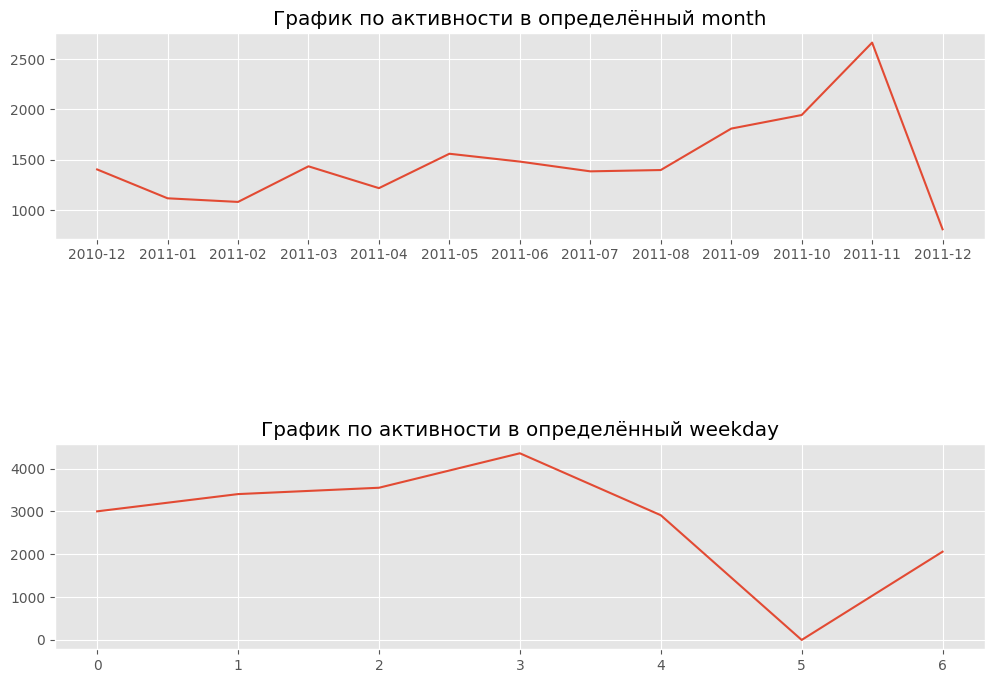

In [63]:
index = 0
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

times = 'month', 'weekday'
bins = 12, 7

for i in range(2):
  temp = st.groupby(times[index])['user_activity'].sum()
  ax[i].plot(temp.index, temp, label='user_activity')
  ax[i].set_title('График по активности в определённый {}'.format(times[index]))
  index += 1

fig.subplots_adjust(hspace=1);

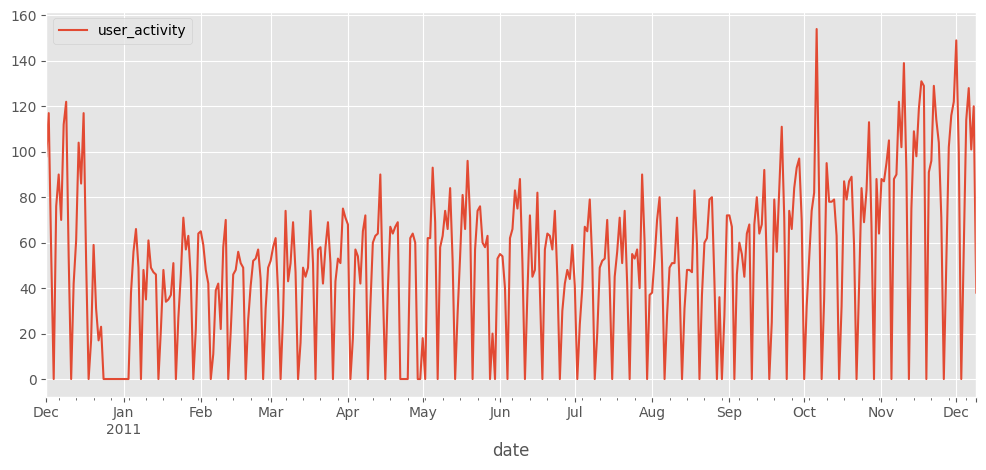

In [64]:
st.plot(x='date', y='user_activity', figsize=(12, 5));

**Вывод**: наблюдается сильная сезонность в данных, по субботам у нас нет никакой активности, а в воскресенье она небольшая по сравнению с будними. Если хотим работать с этими данными, то график нужно сгладить

In [65]:
from statsmodels.tsa.stattools import adfuller
# Проведем тест Дики-Фуллера на стационарность
result = adfuller(st['user_activity'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.415921
p-value: 0.137293
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


На выходе мы получим статистику теста Дики-Фуллера и p-значение. Если p-значение меньше уровня значимости (обычно 0.05), то мы можем отклонить нулевую гипотезу о нестационарности ряда и считать его стационарным. Как можно заметить, ряд нестационарный.

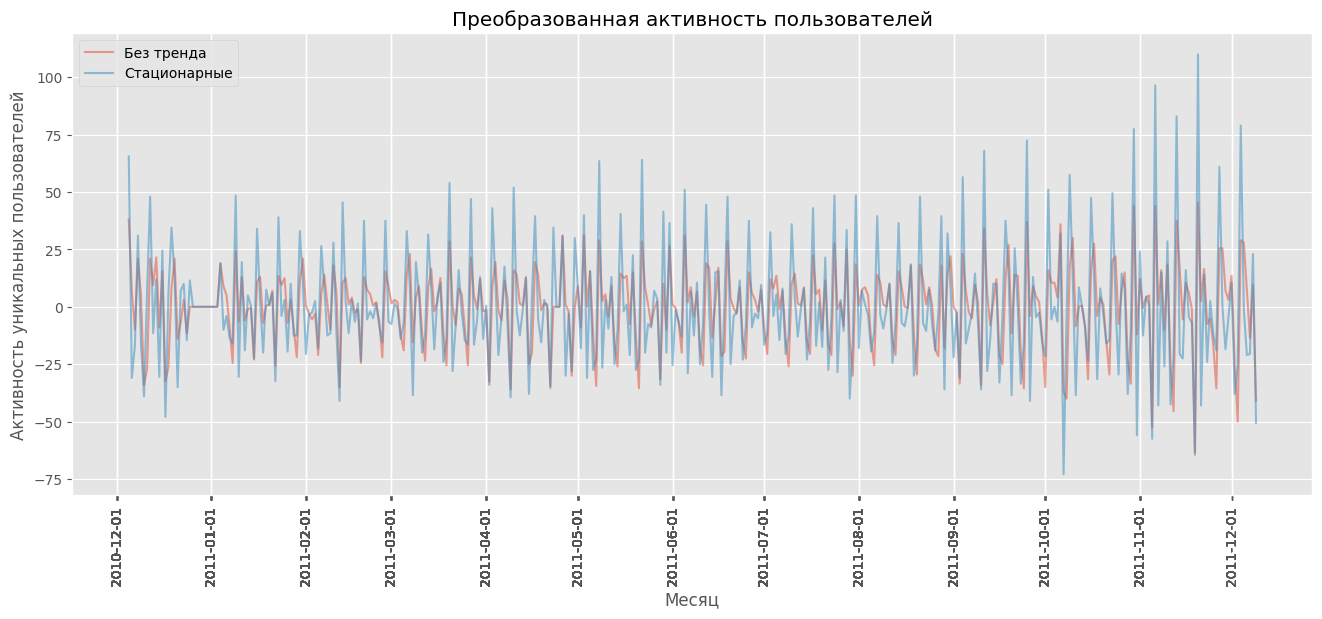

In [68]:
# Преобразование для удаления тренда
st['user_activity_trandless'] = st['user_activity'] - st['user_activity'].rolling(window=2).mean()
# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
st['user_activity_stationary'] = st['user_activity_trandless'].diff()
# Удалим первые строки с пропущенными значениями
st.dropna(inplace=True)

# Построим графики
plt.figure(figsize=(16, 6))
plt.plot(st['date'], st['user_activity_trandless'], label='Без тренда', alpha=0.5)
plt.plot(st['date'], st['user_activity_stationary'], label='Стационарные', alpha=0.5)
plt.legend()
plt.title('Преобразованная активность пользователей')
plt.xlabel('Месяц')
plt.ylabel('Активность уникальных пользователей')
plt.xticks(st['month'].values, rotation=90)
plt.show()

In [67]:
result = adfuller(st['user_activity_stationary'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.361426
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


**Вывод**: Теперь временной ряд стационарный.